In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [48]:
sns.set_style('darkgrid')

In [44]:
pd.set_option('display.max_columns', 40)

# Common Fuctions Across Algorithms

In [56]:
def convert_cat(df, cat_cols, output_var = 'Output'):
    """
    This function converts all categorical columns into numerical boolean columns.
    
    There are 3 parameters: df, cat_cols, and output_var. 
    
    1. df is the dataframe which needs to have categorical variables converted to numerical variables
    2. cat_cols needs to be a list that contains the names of all categorical columns that need to be converted.
    3. output_var is the name of the output or response variable.  It is set to 'Output' as default."""
    
    df.reset_index(inplace = True, drop = True)
    df_out = df.copy()
    
    for col in cat_cols:
        dummy_col = pd.get_dummies(df_out[col],drop_first = True)
        df_out.drop(col,axis=1, inplace = True)
        df_out_minus_y = df_out.drop(output_var,axis= 1).join(dummy_col)
        df_out = df_out_minus_y.join(pd.DataFrame(df_out.loc[:,output_var]))
    
    return df_out

In [57]:
def normalize(df,cat_class = None):
    """
    This function takes in a dataframe as a parameter and returns the same dataframe with all the features normalized between 0 and 1 using rescaling (min-max normalization)
    """
    l_min = []
    l_max = []
    if cat_class == None:
        for col in df.columns:
            l_min.append(df.describe()[col]['min'])
            l_max.append(df.describe()[col]['max'])
        
        t_min = list(zip(df.columns, l_min))
        t_max = list(zip(df.columns, l_max))
 

    else:
        for col in df.drop(cat_class,axis = 1).columns:
            l_min.append(df.describe()[col]['min'])
            l_max.append(df.describe()[col]['max'])

        t_min = list(zip(df.drop(cat_class,axis = 1).columns, l_min))
        t_max = list(zip(df.drop(cat_class,axis = 1).columns, l_max))
    
   
    d_min = {}
    for col,val in t_min:
        d_min[col]=val
    
    d_max = {}
    for col,val in t_max:
        d_max[col]=val
    
    df_copy = df.copy()
    for key in d_min.keys():
        df_copy[key] = df_copy[key].apply(lambda x: (x - d_min[key])/ (d_max[key] - d_min[key]))
    
    return df_copy

In [60]:
def shuffled_split_dfs(df,test_size = 0.3):
    """
    This function takes in a Pandas DataFrame and returns a list of 2
    dataframes.  The first dataframe is the train and the second is the test df.
    
    There are 2 parameters: df and test_size
    
    df needs to be a Pandas DataFrame and is the superset dataframe to be divided.
    test_size is the proportion of the dataframe you want to be the testing dataset.
    test_size is set to 0.3 by default.
    """
    df_copy = df.copy()
    df_copy = df_copy.sample(frac = 1).reset_index(drop = True)
    split_num = int(df_copy.count()[0] * (1-test_size) //1)
    df_train = df_copy.iloc[:split_num,:]
    df_test = df_copy.iloc[split_num:,:]
    return ([df_train,df_test])

In [58]:
def split_df(df,test_size = 0.3,df_to_return = 'df_train'):
    """
    This function takes in a Pandas DataFrame and returns a 
    dataframe that is a subset of that Pandas DataFrame.
    
    There are 3 parameters: df, test_size, and df_to_return
    
    df needs to be a Pandas DataFrame and is the superset dataframe to be divided.
    test_size is the proportion of the dataframe you want to be the testing dataset.
    test_size is set to 0.3 by default.
    df_to_return needs to specified as either 'df_train' or df_test' 
    to return the correct subset dataframe. df_to_return is set to 'df_train' by default
    """
    split_num = int(df.count()[0] * (1-test_size) //1)
    df_train = df.iloc[:split_num,:]
    df_test = df.iloc[split_num:,:]
    if df_to_return in ['df_train','train']:
        return df_train
    elif df_to_return in ['df_test','test']:
        return df_test

In [59]:
def check_accuracy(df = None,pred_df = None, test_df = None, algo = 'lin',target_class = None):
    """
    This function takes in a pandas DataFrame and returns the accuracy of the model
    
    There are 2 parameters: df and algo
    
    1. df needs to be a Pandas DataFrame and algo is the algorithm used.
    2. algo is set to 'lin' by default but can also be specified as 'log'"""
    
    if algo == 'lin':
        df_out = df.copy()
        df_out['error'] = df.iloc[:,-2] - df.iloc[:,-1]
        RMSE = (sum(df_out['error']**2)/df_out.count()[0]+1) ** 0.5
        acc = (np.mean(df_out.iloc[:,-3]) - RMSE) / np.mean(df_out.iloc[:,-3])
        return {'acc':acc,'RMSE':RMSE}
    
    elif algo == 'log':
        return sum(df['Correct?']/df.count()[0])
    
    elif algo == 'knn':
        pred = pred_df[target_class]
        test = test_df[target_class]
        return sum(pred == test) / len(pred)

# Linear and Logistic Regression

In [68]:
def stoch_grad_desc(dataset,alpha = 0.3,epoch = 10,algo = 'lin'):
    """
    This function returns a list of the coefficients for the specified algorithm.  
    Currently, this function only performs Linear and Logistic Regression.
    
    The 4 parameters are: dataset, alpha, epoch, and algo
    
    1. dataset needs to be a pandas DataFrame
    2. alpha is the alpha value used in stochiastic gradient descent.  It is set at 0.3 by default.
    3. epoch is the number of iterations through each row in the dataset algorithm will perform.  epoch is set to 10 by default.
    4. algo is the specific algorithm to be used.  algo is 'lin' by default for Linear Regression but can also be specified as 'log' for Logistic Regression
    """
    dataset.reset_index(inplace = True, drop = True)
    count_rows = dataset.count()[1]
    from math import exp
    dataset_1 = pd.DataFrame(pd.Series(np.ones(dataset.count()[0])),columns = ['X0']).join(dataset)
    
    coeffs = list(np.zeros(len(dataset_1.columns[0:-1])))
    coeffs = [i + 1 for i in coeffs]
    
    for i in range(epoch):
        for row in range(count_rows):
            y = dataset_1.iloc[row,-1]
            output_terms = []
            
            for col in dataset_1.columns[:-1]:
                output_terms.append((coeffs[dataset_1.columns.get_loc(col)],dataset_1.loc[row,col]))
            output_list = [(x*y) for (x,y) in output_terms]
            output = sum(output_list)
            
            if algo == 'lin':
                pred = output
                for i in range(len(coeffs)):
                    coeffs[int(i)] += alpha * (dataset_1.iloc[row,-1] - pred) * dataset_1.iloc[row,int(i)]
                
            elif algo == 'log':
                pred = 1 / (1 + exp(-output))
                for i in range(len(coeffs)):
                    coeffs[i] = coeffs[i] + alpha * (y - pred) * pred * (1 - pred) * dataset_1.iloc[row,i]
                    
    return coeffs
        

In [69]:
def make_predictions(dataset, coeff_list,algo = 'lin'):
    """
    This function takes in a pandas DataFrame and a list that contains 
    coefficients for the specified algorith used in the stoch_grad_desc function
    and returns the same dataset (with the addition of the first column being 1s to
    represent X0 in the regression formula) plus a new column at the end, 'Prediction'.
    
    There are 3 parameters: dataset, coeff_list, and algo
    
    1. dataset is the dataframe to used to make predictions dataset needs to be a Pandas DataFrame
    2. coeff_list should be the list that was the result of running the stoch_grad_desc function
    3. algo is the specific algorithm to be used.  algo is set to 'lin' by default but can be set to 'log'"""
    
    from math import exp
    
    dataset.reset_index(inplace = True, drop = True)
    
    dataset_out = pd.DataFrame(pd.Series(np.ones(dataset.count()[0]))).join(dataset)
    dataset_out.rename(mapper = {0:'X0'},axis = 1, inplace = True)
    
    coeffs = coeff_list
    pred = []
    
    for row in range(dataset_out.count()[0]):
        output_terms = []
        for col in dataset_out.columns[0:-1]:
            output_terms.append((coeffs[dataset_out.columns.get_loc(col)],dataset_out.loc[row,col]))
        output_list = [x*y for (x,y) in output_terms]
        
        output = sum(output_list)
        if algo == 'lin':
            pred.append(output)
        
        elif algo == 'log':
            pred.append(1/(1 + exp(-output)))
    dataset_out = dataset_out.join(pd.DataFrame(pred))
    dataset_out.rename(mapper = {0: 'Prediction'},axis = 1, inplace = True)
    
    if algo == 'log':
        dataset_out['Crisp'] = dataset_out['Prediction'].apply(lambda predi: 1 if predi >= 0.5 else 0)
        dataset_out['Correct?'] = dataset_out.iloc[:,-3] == dataset_out['Crisp']
    
    return dataset_out

# K Nearest Neighbors

In [8]:
def knn_1pt(df,new_point,output_col,k = 3):
    import statistics
    df1 = df.copy()
    new_pt_df = pd.DataFrame(data = [new_point + ['DK']],columns=df.columns)
    df_out = df1.append(new_pt_df,ignore_index = True)
    
    df2 = df_out.drop(output_col,axis=1)
    count_rows = df2.count()[0]
    new_pt_ind = count_rows - 1
    df2['sum_sqrd_diffs'] = 0
    for row_num in range(0,count_rows):
        sum_sqrd_diffs = 0
        for col_num in range(0,len(df2.columns)):
            sum_sqrd_diffs += (df2.iloc[new_pt_ind,col_num] - df2.iloc[row_num,col_num])**2
        df_out.loc[row_num,'sum_sqrd_diffs'] = sum_sqrd_diffs 
       
    df_out.loc[new_pt_ind,output_col] = statistics.mode(df_out.iloc[:new_pt_ind,:].sort_values('sum_sqrd_diffs').head(k)[output_col])
    #return df_out.sort_values('sum_sqrd_diffs').head(10)
    return df_out
              
    

In [118]:
def knn(df_train,new_pts_list,dep_col,k = 7,only_pred_df = True):
    from time import time
    start_time = time()
    import statistics
    
    nrows_new_pts = new_pts_list.shape[0]
    loc_dep_col = list(df_train.columns).index(dep_col)
    df_in = df_train[list(df_train.columns)[0:loc_dep_col] + list(df_train.columns)[loc_dep_col + 1:] + list(df_train.columns)[loc_dep_col:loc_dep_col + 1]] 
    
    if type(new_pts_list) == type(df_in):
        l_list_new_pts = []
        
        for rn in range(new_pts_list.count()[0]):
            l_list_new_pts.append(list(new_pts_list.iloc[rn,:]))
        new_pts_list = l_list_new_pts

    def knn_1pt(df,new_point,output_col = dep_col,k = k):
        
        df1 = df.copy()
        new_pt_df = pd.DataFrame(data = [new_point + ['DK']],columns=df1.columns)
        df_out = df1.append(new_pt_df,ignore_index = True)

        df2 = df_out.drop(output_col,axis=1)
        count_rows = df2.count()[0]
        new_pt_ind = count_rows - 1
        df2['sum_sqrd_diffs'] = 0
        for row_num in range(0,count_rows):
            sum_sqrd_diffs = 0
            for col_num in range(0,len(df2.columns)):
                sum_sqrd_diffs += (df2.iloc[new_pt_ind,col_num] - df2.iloc[row_num,col_num])**2
            df_out.loc[row_num,'sum_sqrd_diffs'] = sum_sqrd_diffs 
            
        
        if k == 1:
            df_out.loc[new_pt_ind,output_col] = statistics.mode(df_out.iloc[:new_pt_ind,:].sort_values('sum_sqrd_diffs').head(k)[output_col])
            df_in = df_out.drop('sum_sqrd_diffs',axis = 1).copy()
        else:
            try:
                mode = statistics.mode(df_out.sort_values('sum_sqrd_diffs')[0:k][output_col])
            except:
                closest = list(df_out.sort_values('sum_sqrd_diffs')[0:k][output_col].values)
                copy = closest[:]
                closest.sort(key = lambda x:copy.count(x))
                closest.reverse()
                mode = closest[0]
            df_out.loc[new_pt_ind,output_col] = mode
            df_in = df_out.drop('sum_sqrd_diffs',axis = 1).copy()
        return df_in
    

        
    
    for np in new_pts_list:
        df_in =  knn_1pt(new_point = np,df=df_in).copy()
    
    end_time = time()
    print("Program took %s seconds to run." % (end_time - start_time))
    if only_pred_df == True:
        return df_in[-nrows_new_pts:]
    return df_in

# Loading Data Frame and doing preliminary EDA

In [4]:
cervical = pd.read_csv(r'kag_risk_factors_cervical_cancer.csv')

In [5]:
cervical.head()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
2,34,1.0,?,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,...,?,?,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,...,?,?,0,0,0,0,0,0,0,0


In [6]:
cervical.describe()

,Age,STDs: Number of diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
count,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000
mean,26.820513,0.087413,0.020979,0.010490,0.020979,0.027972,0.040793,0.086247,0.051282,0.064103
std,8.497948,0.302545,0.143398,0.101939,0.143398,0.164989,0.197925,0.280892,0.220701,0.245078
min,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,32.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,84.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
cervical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 36 columns):
Age                                   858 non-null int64
Number of sexual partners             858 non-null object
First sexual intercourse              858 non-null object
Num of pregnancies                    858 non-null object
Smokes                                858 non-null object
Smokes (years)                        858 non-null object
Smokes (packs/year)                   858 non-null object
Hormonal Contraceptives               858 non-null object
Hormonal Contraceptives (years)       858 non-null object
IUD                                   858 non-null object
IUD (years)                           858 non-null object
STDs                                  858 non-null object
STDs (number)                         858 non-null object
STDs:condylomatosis                   858 non-null object
STDs:cervical condylomatosis          858 non-null object
STDs:vaginal condylomatosi

In [8]:
# Checking for null values: there aren't any, but later on, I found null values had a '?' instead
cervical.isna().sum()

Age                                   0
Number of sexual partners             0
First sexual intercourse              0
Num of pregnancies                    0
Smokes                                0
Smokes (years)                        0
Smokes (packs/year)                   0
Hormonal Contraceptives               0
Hormonal Contraceptives (years)       0
IUD                                   0
IUD (years)                           0
STDs                                  0
STDs (number)                         0
STDs:condylomatosis                   0
STDs:cervical condylomatosis          0
STDs:vaginal condylomatosis           0
STDs:vulvo-perineal condylomatosis    0
STDs:syphilis                         0
STDs:pelvic inflammatory disease      0
STDs:genital herpes                   0
STDs:molluscum contagiosum            0
STDs:AIDS                             0
STDs:HIV                              0
STDs:Hepatitis B                      0
STDs:HPV                              0


In [9]:
plt.rcParams['figure.figsize'] = (15,10)

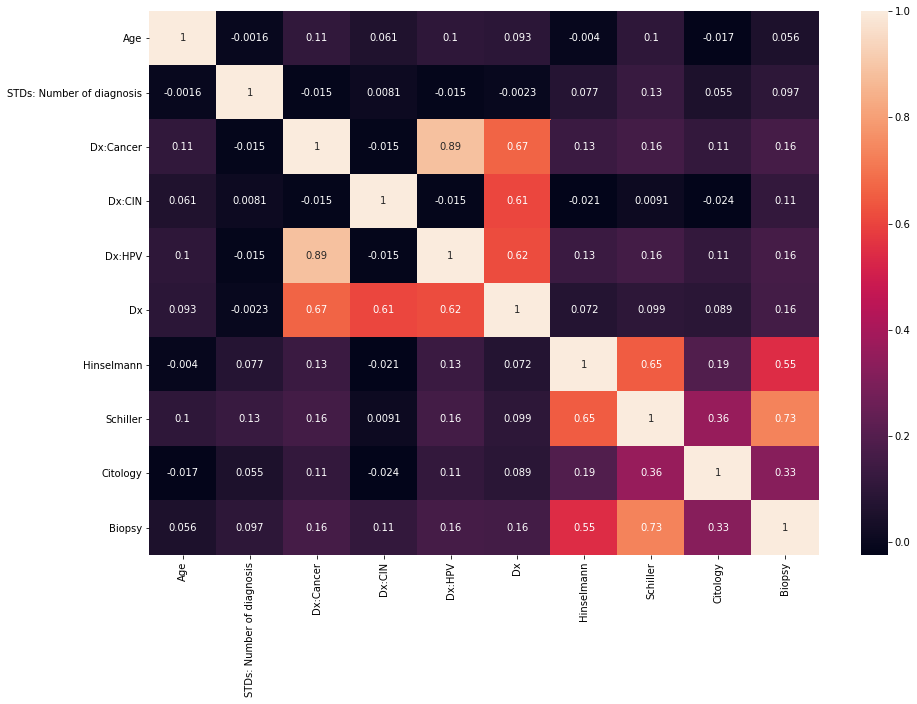

In [10]:
# Looking for multicolinearity and seeing what input variables have most correlation with output variable 'Biopsy'
sns.heatmap(cervical.corr(),annot=True)

In [11]:
#Checking why 'STDs' is not showing up in heat map
cervical['STDs'].value_counts()

0.0    674
?      105
1.0     79
Name: STDs, dtype: int64

In [12]:
cervical.columns

Index(['Age', 'Number of sexual partners', 'First sexual intercourse',
       'Num of pregnancies', 'Smokes', 'Smokes (years)', 'Smokes (packs/year)',
       'Hormonal Contraceptives', 'Hormonal Contraceptives (years)', 'IUD',
       'IUD (years)', 'STDs', 'STDs (number)', 'STDs:condylomatosis',
       'STDs:cervical condylomatosis', 'STDs:vaginal condylomatosis',
       'STDs:vulvo-perineal condylomatosis', 'STDs:syphilis',
       'STDs:pelvic inflammatory disease', 'STDs:genital herpes',
       'STDs:molluscum contagiosum', 'STDs:AIDS', 'STDs:HIV',
       'STDs:Hepatitis B', 'STDs:HPV', 'STDs: Number of diagnosis',
       'STDs: Time since first diagnosis', 'STDs: Time since last diagnosis',
       'Dx:Cancer', 'Dx:CIN', 'Dx:HPV', 'Dx', 'Hinselmann', 'Schiller',
       'Citology', 'Biopsy'],
      dtype='object')

In [13]:
# creating a dictionary where all the keys are the columns and the values are lists containing tuple pairs 
# where 1st value is the value and 2nd value is the number of occurences of that value

d_col_value_counts = {}
for col in cervical.columns:
    d_col_value_counts[col] = list(cervical[col].value_counts().items())

In [14]:
d_col_value_counts

{'Age': [(23, 54),
  (18, 50),
  (21, 46),
  (20, 45),
  (19, 44),
  (24, 39),
  (25, 39),
  (26, 38),
  (28, 37),
  (30, 35),
  (17, 35),
  (29, 33),
  (27, 33),
  (22, 30),
  (35, 29),
  (33, 28),
  (31, 27),
  (36, 24),
  (34, 24),
  (16, 23),
  (15, 21),
  (32, 18),
  (37, 17),
  (41, 13),
  (40, 12),
  (39, 9),
  (38, 9),
  (45, 6),
  (44, 6),
  (42, 6),
  (43, 5),
  (14, 5),
  (46, 3),
  (48, 2),
  (49, 2),
  (52, 2),
  (70, 2),
  (84, 1),
  (79, 1),
  (47, 1),
  (50, 1),
  (51, 1),
  (59, 1),
  (13, 1)],
 'Biopsy': [(0, 803), (1, 55)],
 'Citology': [(0, 814), (1, 44)],
 'Dx': [(0, 834), (1, 24)],
 'Dx:CIN': [(0, 849), (1, 9)],
 'Dx:Cancer': [(0, 840), (1, 18)],
 'Dx:HPV': [(0, 840), (1, 18)],
 'First sexual intercourse': [('15.0', 163),
  ('17.0', 151),
  ('18.0', 137),
  ('16.0', 121),
  ('14.0', 79),
  ('19.0', 60),
  ('20.0', 37),
  ('13.0', 25),
  ('21.0', 20),
  ('22.0', 9),
  ('23.0', 9),
  ('?', 7),
  ('26.0', 7),
  ('12.0', 6),
  ('24.0', 6),
  ('27.0', 6),
  ('29.0', 5)

In [15]:
# Creating a list with all columns that have '?' instead of NaN
l_question_mark_cols = []
for col in d_col_value_counts.keys():

    flag_true = 0
    for value in d_col_value_counts[col]:
        if '?' in value:
            l_question_mark_cols.append(col)

In [16]:
l_question_mark_cols

['Number of sexual partners',
 'First sexual intercourse',
 'Num of pregnancies',
 'Smokes',
 'Smokes (years)',
 'Smokes (packs/year)',
 'Hormonal Contraceptives',
 'Hormonal Contraceptives (years)',
 'IUD',
 'IUD (years)',
 'STDs',
 'STDs (number)',
 'STDs:condylomatosis',
 'STDs:cervical condylomatosis',
 'STDs:vaginal condylomatosis',
 'STDs:vulvo-perineal condylomatosis',
 'STDs:syphilis',
 'STDs:pelvic inflammatory disease',
 'STDs:genital herpes',
 'STDs:molluscum contagiosum',
 'STDs:AIDS',
 'STDs:HIV',
 'STDs:Hepatitis B',
 'STDs:HPV',
 'STDs: Time since first diagnosis',
 'STDs: Time since last diagnosis']

In [17]:
# Checking the list previously made
cervical[cervical == '?'].count()

Age                                     0
Number of sexual partners              26
First sexual intercourse                7
Num of pregnancies                     56
Smokes                                 13
Smokes (years)                         13
Smokes (packs/year)                    13
Hormonal Contraceptives               108
Hormonal Contraceptives (years)       108
IUD                                   117
IUD (years)                           117
STDs                                  105
STDs (number)                         105
STDs:condylomatosis                   105
STDs:cervical condylomatosis          105
STDs:vaginal condylomatosis           105
STDs:vulvo-perineal condylomatosis    105
STDs:syphilis                         105
STDs:pelvic inflammatory disease      105
STDs:genital herpes                   105
STDs:molluscum contagiosum            105
STDs:AIDS                             105
STDs:HIV                              105
STDs:Hepatitis B                  

In [18]:
# Replacing all '?' values with NaN
for col in l_question_mark_cols:
    cervical[col] = cervical[col].apply(lambda val: np.nan if val == '?' else val)

In [19]:
cervical['STDs:HIV'].value_counts()

0.0    735
1.0     18
Name: STDs:HIV, dtype: int64

In [20]:
cervical.isna().sum()

Age                                     0
Number of sexual partners              26
First sexual intercourse                7
Num of pregnancies                     56
Smokes                                 13
Smokes (years)                         13
Smokes (packs/year)                    13
Hormonal Contraceptives               108
Hormonal Contraceptives (years)       108
IUD                                   117
IUD (years)                           117
STDs                                  105
STDs (number)                         105
STDs:condylomatosis                   105
STDs:cervical condylomatosis          105
STDs:vaginal condylomatosis           105
STDs:vulvo-perineal condylomatosis    105
STDs:syphilis                         105
STDs:pelvic inflammatory disease      105
STDs:genital herpes                   105
STDs:molluscum contagiosum            105
STDs:AIDS                             105
STDs:HIV                              105
STDs:Hepatitis B                  

In [21]:
# Dropping two columns that have high number of null values
cervical.drop(['STDs: Time since first diagnosis','STDs: Time since last diagnosis'],axis =1,inplace=True)

In [22]:
# Dropping all null values
cervical.dropna(inplace = True)

In [23]:
cervical.reset_index(inplace=True)

In [24]:
cervical.isna().sum()

index                                 0
Age                                   0
Number of sexual partners             0
First sexual intercourse              0
Num of pregnancies                    0
Smokes                                0
Smokes (years)                        0
Smokes (packs/year)                   0
Hormonal Contraceptives               0
Hormonal Contraceptives (years)       0
IUD                                   0
IUD (years)                           0
STDs                                  0
STDs (number)                         0
STDs:condylomatosis                   0
STDs:cervical condylomatosis          0
STDs:vaginal condylomatosis           0
STDs:vulvo-perineal condylomatosis    0
STDs:syphilis                         0
STDs:pelvic inflammatory disease      0
STDs:genital herpes                   0
STDs:molluscum contagiosum            0
STDs:AIDS                             0
STDs:HIV                              0
STDs:Hepatitis B                      0


In [25]:
cervical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 668 entries, 0 to 667
Data columns (total 35 columns):
index                                 668 non-null int64
Age                                   668 non-null int64
Number of sexual partners             668 non-null object
First sexual intercourse              668 non-null object
Num of pregnancies                    668 non-null object
Smokes                                668 non-null object
Smokes (years)                        668 non-null object
Smokes (packs/year)                   668 non-null object
Hormonal Contraceptives               668 non-null object
Hormonal Contraceptives (years)       668 non-null object
IUD                                   668 non-null object
IUD (years)                           668 non-null object
STDs                                  668 non-null object
STDs (number)                         668 non-null object
STDs:condylomatosis                   668 non-null object
STDs:cervical condylomatosi

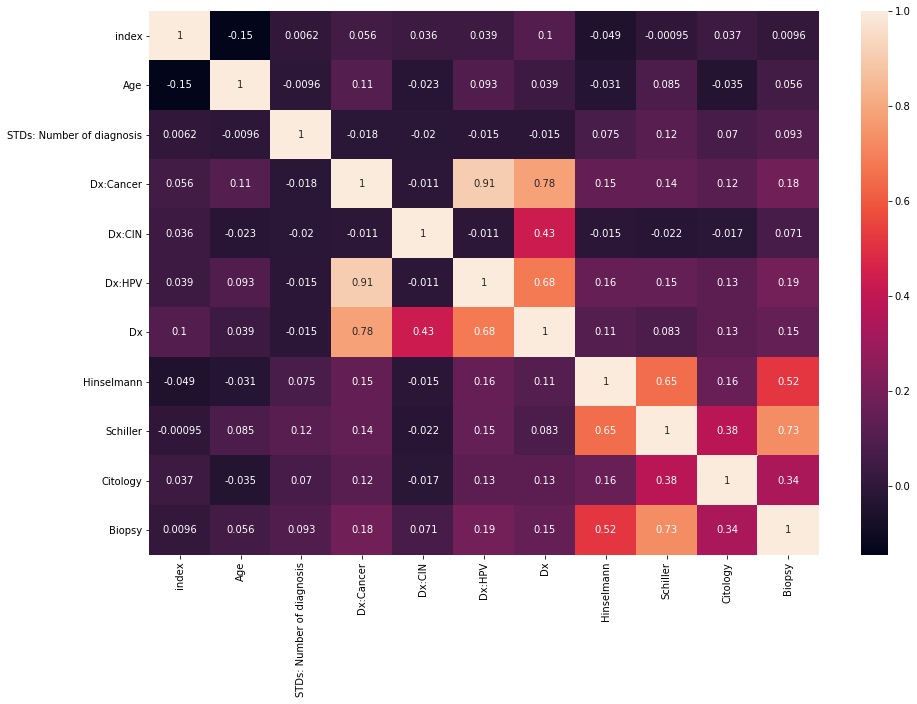

In [26]:
sns.heatmap(cervical.corr(),annot = True)

In [27]:
# Several columns are not showing up in heat map still because they contain string values rather than integers or floats
cervical[cervical['STDs:HPV'] == '0.0']['STDs:HPV'].count()

666

In [28]:
# Creating a list of all columns that only have numerical values
l_int_columns = list(cervical.corr().index)

In [29]:
# Creating a list that has string values instead of numerical values
l_string_columns = []
for col in cervical.columns:
    if col not in l_int_columns:
        l_string_columns.append(col)

In [30]:
l_string_columns

['Number of sexual partners',
 'First sexual intercourse',
 'Num of pregnancies',
 'Smokes',
 'Smokes (years)',
 'Smokes (packs/year)',
 'Hormonal Contraceptives',
 'Hormonal Contraceptives (years)',
 'IUD',
 'IUD (years)',
 'STDs',
 'STDs (number)',
 'STDs:condylomatosis',
 'STDs:cervical condylomatosis',
 'STDs:vaginal condylomatosis',
 'STDs:vulvo-perineal condylomatosis',
 'STDs:syphilis',
 'STDs:pelvic inflammatory disease',
 'STDs:genital herpes',
 'STDs:molluscum contagiosum',
 'STDs:AIDS',
 'STDs:HIV',
 'STDs:Hepatitis B',
 'STDs:HPV']

In [31]:
# Converting all string columns into int columns
for col in l_string_columns:
     cervical[col] = cervical[col].apply(lambda val: int(val.split('.')[0]))

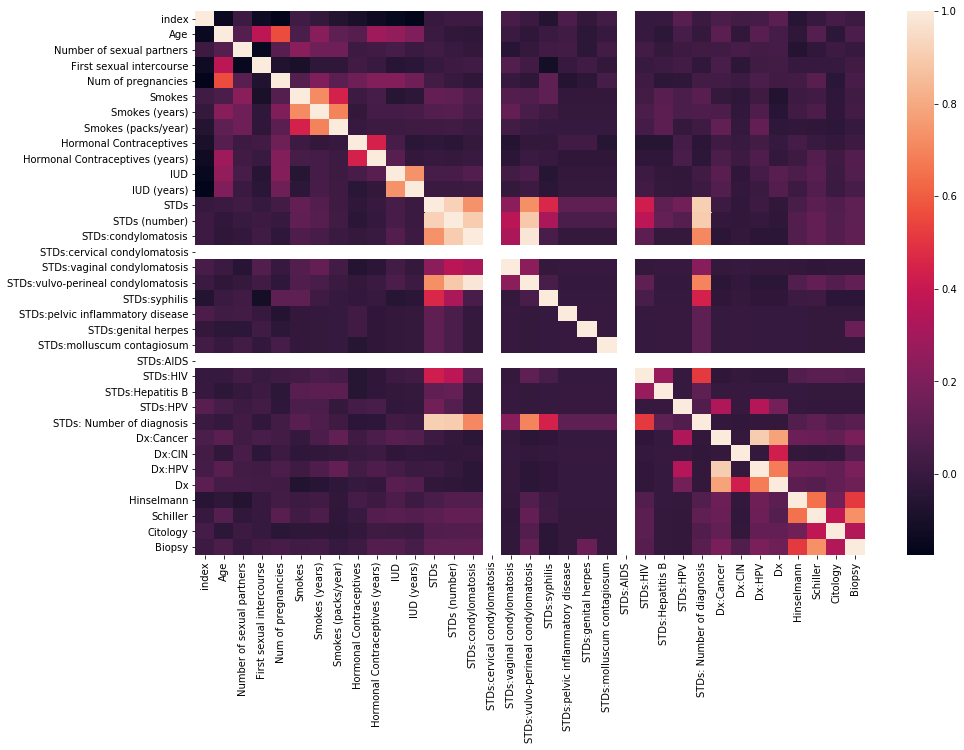

In [32]:
sns.heatmap(data = cervical.corr())

In [33]:
# 2 columns are not showing up in heat map because they only have one class of values
cervical['STDs:cervical condylomatosis'].value_counts()

0    668
Name: STDs:cervical condylomatosis, dtype: int64

In [34]:
# Dropping columns 'STDs:cervical condylomatosis' and 'STDs:AIDS' since they only have one category of values
cervical.drop(['STDs:cervical condylomatosis','STDs:AIDS'],axis = 1,inplace = True)

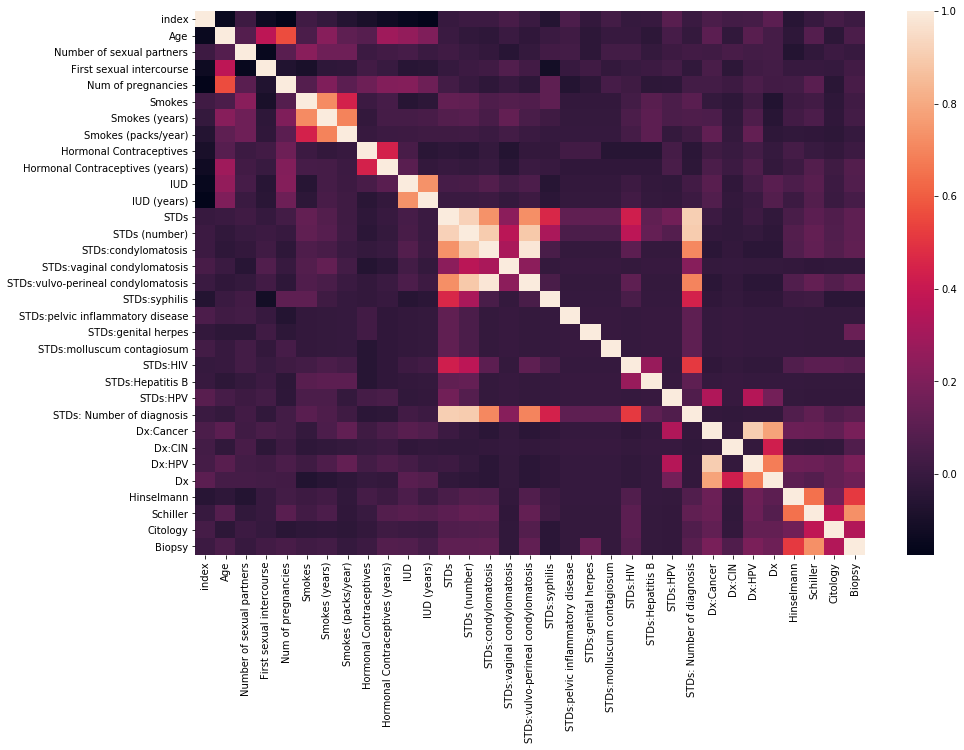

In [35]:
sns.heatmap(cervical.corr())

# Further EDA

In [45]:
cervical.describe()

,index,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,IUD (years),STDs,STDs (number),STDs:condylomatosis,STDs:vaginal condylomatosis,STDs:vulvo-perineal condylomatosis,STDs:syphilis,STDs:pelvic inflammatory disease,STDs:genital herpes,STDs:molluscum contagiosum,STDs:HIV,STDs:Hepatitis B,STDs:HPV,STDs: Number of diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
count,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000
mean,417.121257,27.264970,2.523952,17.142216,2.323353,0.143713,1.229042,0.419162,0.643713,2.224551,0.112275,0.523952,0.097305,0.166168,0.055389,0.005988,0.053892,0.022455,0.001497,0.001497,0.001497,0.019461,0.001497,0.002994,0.092814,0.025449,0.004491,0.023952,0.023952,0.044910,0.094311,0.058383,0.067365
std,246.590031,8.727432,1.640299,2.852046,1.465319,0.351061,4.194298,2.322769,0.479260,3.756916,0.315942,2.001730,0.296595,0.551073,0.228910,0.077208,0.225974,0.148269,0.038691,0.038691,0.038691,0.138242,0.038691,0.054677,0.310355,0.157603,0.066915,0.153015,0.153015,0.207262,0.292480,0.234642,0.250841
min,0.000000,13.000000,1.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,202.750000,21.000000,2.000000,15.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,421.000000,26.000000,2.000000,17.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,621.250000,33.000000,3.000000,18.000000,3.000000,0.000000,0.000000,0.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,857.000000,84.000000,28.000000,32.000000,11.000000,1.000000,37.000000,37.000000,1.000000,22.000000,1.000000,19.000000,1.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [40]:
cervical.head(2)

,index,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),...,STDs:HPV,STDs: Number of diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,0,18,4,15,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,15,1,14,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
cervical.columns

Index(['index', 'Age', 'Number of sexual partners', 'First sexual intercourse',
       'Num of pregnancies', 'Smokes', 'Smokes (years)', 'Smokes (packs/year)',
       'Hormonal Contraceptives', 'Hormonal Contraceptives (years)', 'IUD',
       'IUD (years)', 'STDs', 'STDs (number)', 'STDs:condylomatosis',
       'STDs:vaginal condylomatosis', 'STDs:vulvo-perineal condylomatosis',
       'STDs:syphilis', 'STDs:pelvic inflammatory disease',
       'STDs:genital herpes', 'STDs:molluscum contagiosum', 'STDs:HIV',
       'STDs:Hepatitis B', 'STDs:HPV', 'STDs: Number of diagnosis',
       'Dx:Cancer', 'Dx:CIN', 'Dx:HPV', 'Dx', 'Hinselmann', 'Schiller',
       'Citology', 'Biopsy'],
      dtype='object')

C:\Users\ssiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


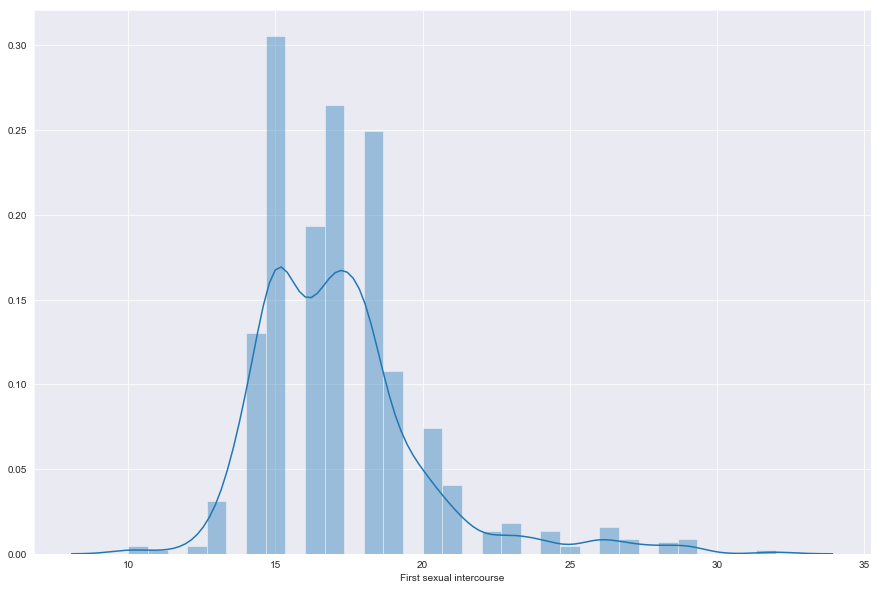

In [121]:
sns.distplot(a = cervical['First sexual intercourse'])

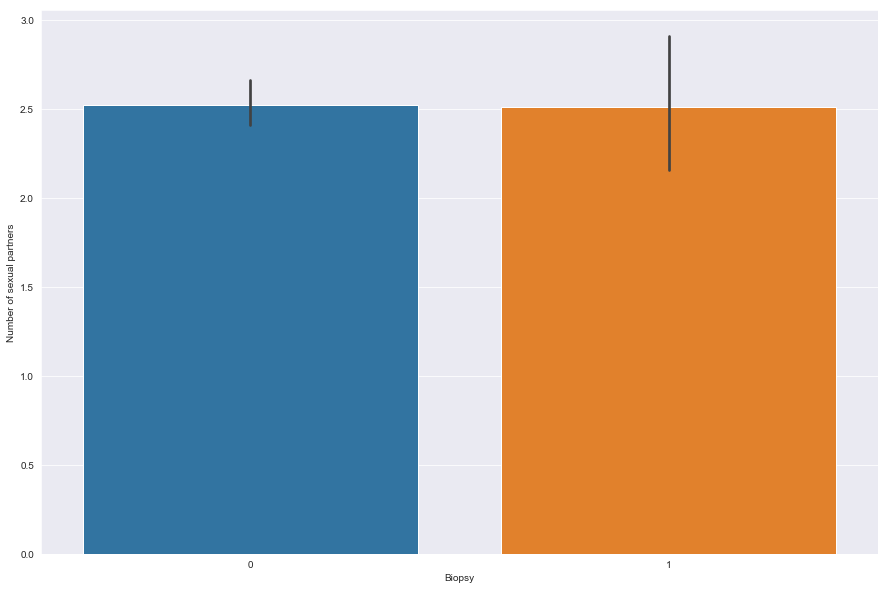

In [50]:
# Created a barplot showing average number of sexual partners for both groups (patients with and without cervical cancer)
sns.barplot(data = cervical,x = 'Biopsy', y = 'Number of sexual partners')

### From above plot, it seems that having more sexual partners does not preclude a patient to having a higher chance of cervical cancer

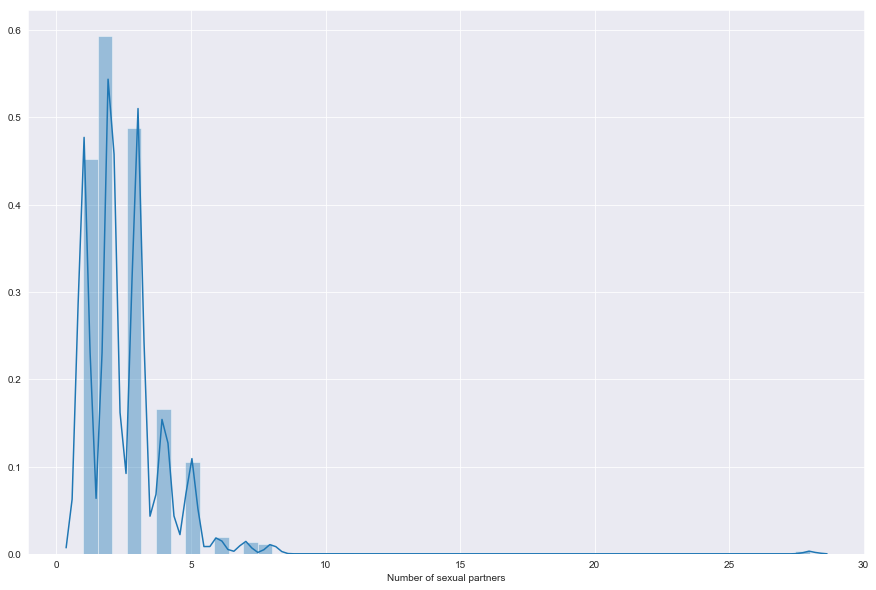

In [52]:
# Creating a distplot of patients based on number of sexual partners they have had
sns.distplot(a = cervical['Number of sexual partners'])

C:\Users\ssiva\Anaconda3\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


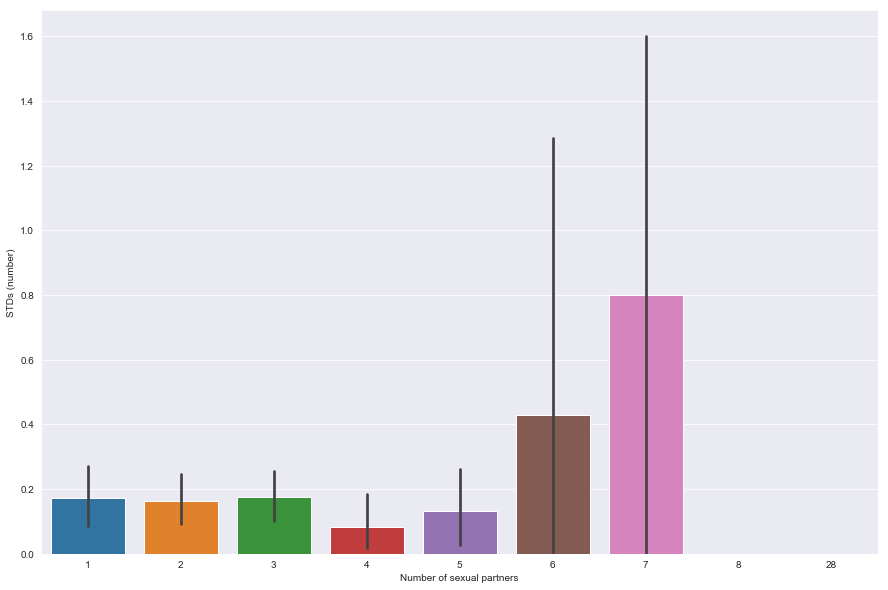

In [124]:
# Created a barplot showing the average number of STDs for each number of sexual partners
sns.barplot(data = cervical,x = 'Number of sexual partners', y = 'STDs (number)')

### From the above plot, there seems to be some correlation between number of sexual partners and number of STDs but only at higher number of partners

In [54]:
cervical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 668 entries, 0 to 667
Data columns (total 33 columns):
index                                 668 non-null int64
Age                                   668 non-null int64
Number of sexual partners             668 non-null int64
First sexual intercourse              668 non-null int64
Num of pregnancies                    668 non-null int64
Smokes                                668 non-null int64
Smokes (years)                        668 non-null int64
Smokes (packs/year)                   668 non-null int64
Hormonal Contraceptives               668 non-null int64
Hormonal Contraceptives (years)       668 non-null int64
IUD                                   668 non-null int64
IUD (years)                           668 non-null int64
STDs                                  668 non-null int64
STDs (number)                         668 non-null int64
STDs:condylomatosis                   668 non-null int64
STDs:vaginal condylomatosis           66

# Logarithmic Model

In [61]:
cervical_log = normalize(cervical,cat_class = 'Biopsy')

In [62]:
cervical_log.head()

,index,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,IUD (years),STDs,STDs (number),STDs:condylomatosis,STDs:vaginal condylomatosis,STDs:vulvo-perineal condylomatosis,STDs:syphilis,STDs:pelvic inflammatory disease,STDs:genital herpes,STDs:molluscum contagiosum,STDs:HIV,STDs:Hepatitis B,STDs:HPV,STDs: Number of diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,0.000000,0.070423,0.111111,0.227273,0.090909,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.001167,0.028169,0.000000,0.181818,0.090909,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.003501,0.549296,0.148148,0.272727,0.363636,1.0,1.0,1.0,1.0,0.136364,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0
3,0.004667,0.464789,0.074074,0.500000,0.363636,0.0,0.0,0.0,1.0,0.681818,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.005834,0.408451,0.074074,0.590909,0.181818,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [63]:
[cervical_log_train,cervical_log_test] = shuffled_split_dfs(cervical_log)

In [65]:
cervical_log_train.head()

,index,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,IUD (years),STDs,STDs (number),STDs:condylomatosis,STDs:vaginal condylomatosis,STDs:vulvo-perineal condylomatosis,STDs:syphilis,STDs:pelvic inflammatory disease,STDs:genital herpes,STDs:molluscum contagiosum,STDs:HIV,STDs:Hepatitis B,STDs:HPV,STDs: Number of diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,0.242707,0.197183,0.111111,0.272727,0.090909,0.0,0.000000,0.0,1.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.011669,0.436620,0.074074,0.727273,0.363636,0.0,0.000000,0.0,1.0,0.090909,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.275379,0.154930,0.037037,0.227273,0.272727,0.0,0.000000,0.0,1.0,0.181818,0.0,0.0,1.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.886814,0.056338,0.000000,0.227273,0.181818,0.0,0.000000,0.0,1.0,0.000000,0.0,0.0,1.0,0.50,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.750292,0.028169,0.111111,0.181818,0.090909,1.0,0.027027,0.0,1.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0


In [66]:
cervical_log_test.head()

,index,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,IUD (years),STDs,STDs (number),STDs:condylomatosis,STDs:vaginal condylomatosis,STDs:vulvo-perineal condylomatosis,STDs:syphilis,STDs:pelvic inflammatory disease,STDs:genital herpes,STDs:molluscum contagiosum,STDs:HIV,STDs:Hepatitis B,STDs:HPV,STDs: Number of diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
467,0.037340,0.338028,0.074074,0.318182,0.454545,1.0,0.027027,0.0,1.0,0.454545,0.0,0.000000,1.0,0.25,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
468,0.340723,0.126761,0.037037,0.318182,0.272727,0.0,0.000000,0.0,1.0,0.000000,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
469,0.224037,0.197183,0.037037,0.318182,0.363636,0.0,0.000000,0.0,1.0,0.090909,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
470,0.120187,0.352113,0.074074,0.363636,0.363636,0.0,0.000000,0.0,1.0,0.454545,1.0,0.105263,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1
471,0.379230,0.098592,0.000000,0.409091,0.090909,0.0,0.000000,0.0,1.0,0.000000,0.0,0.000000,1.0,0.25,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [70]:
cervical_log_coeffs = stoch_grad_desc(dataset = cervical_log_train,alpha = 0.2,algo = 'log')

In [71]:
cervical_log_coeffs

[-3.2215197105759303,
 -0.013900433180148785,
 0.06893558822817185,
 0.7299151666564536,
 -0.19317514797089447,
 -0.21484057922362726,
 -0.30632749701756046,
 0.4437879172820179,
 0.7455844480400716,
 -0.9148962645816489,
 0.6882375769409448,
 0.1761729124584373,
 0.7313189623262624,
 -0.29628597162611314,
 0.43450835050023096,
 0.4998161566627117,
 0.7022131930480948,
 0.4998161566627117,
 0.5336375460774803,
 0.9802965141985304,
 1.0,
 0.9458489280512696,
 0.8459095858380886,
 0.8699173449266889,
 0.8605779765353492,
 0.5726073046988217,
 0.46646940424330885,
 1.1933477329812667,
 0.47326137100025367,
 0.6936394914946232,
 1.0885165292155845,
 2.772572735575001,
 1.0415560909664363]

In [72]:
cervical_log_prediction_df = make_predictions(dataset = cervical_log_test,coeff_list=cervical_log_coeffs,algo = 'log')

In [73]:
cervical_log_prediction_df

,X0,index,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,IUD (years),STDs,STDs (number),STDs:condylomatosis,STDs:vaginal condylomatosis,STDs:vulvo-perineal condylomatosis,STDs:syphilis,STDs:pelvic inflammatory disease,STDs:genital herpes,STDs:molluscum contagiosum,STDs:HIV,STDs:Hepatitis B,STDs:HPV,STDs: Number of diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy,Prediction,Crisp,Correct?
0,1.0,0.037340,0.338028,0.074074,0.318182,0.454545,1.0,0.027027,0.000000,1.0,0.454545,0.0,0.000000,1.0,0.25,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.020751,0,True
1,1.0,0.340723,0.126761,0.037037,0.318182,0.272727,0.0,0.000000,0.000000,1.0,0.000000,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.014408,0,True
2,1.0,0.224037,0.197183,0.037037,0.318182,0.363636,0.0,0.000000,0.000000,1.0,0.090909,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.015129,0,True
3,1.0,0.120187,0.352113,0.074074,0.363636,0.363636,0.0,0.000000,0.000000,1.0,0.454545,1.0,0.105263,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1,0.542895,1,True
4,1.0,0.379230,0.098592,0.000000,0.409091,0.090909,0.0,0.000000,0.000000,1.0,0.000000,0.0,0.000000,1.0,0.25,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.038044,0,False
5,1.0,0.141190,0.239437,0.148148,0.227273,0.272727,0.0,0.000000,0.000000,1.0,0.272727,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.019293,0,True
6,1.0,0.499417,0.042254,0.000000,0.227273,0.090909,1.0,0.027027,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.027032,0,True
7,1.0,0.676779,0.056338,0.037037,0.227273,0.090909,0.0,0.000000,0.000000,1.0,0.000000,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.015093,0,True
8,1.0,0.572929,0.084507,0.000000,0.318182,0.090909,0.0,0.000000,0.000000,1.0,0.045455,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.014946,0,True
9,1.0,0.709452,0.084507,0.037037,0.272727,0.090909,0.0,0.000000,0.000000,1.0,0.090909,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.015937,0,True


In [74]:
check_accuracy(df = cervical_log_prediction_df,algo = 'log')

0.9552238805970119

In [75]:
from sklearn.metrics import classification_report,confusion_matrix

In [76]:
print(confusion_matrix(y_true = cervical_log_prediction_df['Biopsy'],y_pred = cervical_log_prediction_df['Crisp']))

[[185   1]
 [  8   7]]


In [77]:
# My logarithmic model was able to predict about 62% of all positive patients
print(classification_report(y_true = cervical_log_prediction_df['Biopsy'],y_pred = cervical_log_prediction_df['Crisp']))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       186
           1       0.88      0.47      0.61        15

    accuracy                           0.96       201
   macro avg       0.92      0.73      0.79       201
weighted avg       0.95      0.96      0.95       201



#### My Logistic Regression Model had a recall of 0.96 and a precision of 0.95 which is very good.  However, when it comes to cancer biopsies, recall of the positive (1) cases is most important.  From the classification report, I had a recall of 0.47 for positive test results.

# Scikit-Learn Logistic Regression Model

In [78]:
X = cervical.drop('Biopsy',axis = 1)
y = cervical['Biopsy']

In [79]:
from sklearn.model_selection import train_test_split

In [80]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3)

In [81]:
from sklearn.linear_model import LogisticRegression

In [82]:
skl_log = LogisticRegression()

In [83]:
skl_log.fit(X_train,y_train)

C:\Users\ssiva\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [84]:
list(skl_log.coef_[0])

[-0.0013599695299812504,
 0.0022805297357021983,
 0.07007522930621972,
 -0.21410274158748055,
 -0.035189412500226405,
 0.16953660059066405,
 -0.19279438181908992,
 0.26468170043447264,
 -0.10336256970554854,
 0.06395777000675046,
 0.009578058748163676,
 -0.1995497515570964,
 0.1370613110250712,
 0.21519303000442713,
 0.20040938861045157,
 -0.04287702852236172,
 0.2142411451420106,
 -0.2134994371551994,
 -0.006021590388793663,
 0.0,
 -0.006742634796436333,
 0.08102154459604499,
 0.0,
 -0.011338357481299409,
 -0.09227051659574097,
 0.47367555441316994,
 -0.012746866497818204,
 0.4695792530401058,
 0.2460654615229046,
 1.6022439354756326,
 3.0141755152828944,
 0.9755613063480559]

In [85]:
cervical_log_coeffs

[-3.2215197105759303,
 -0.013900433180148785,
 0.06893558822817185,
 0.7299151666564536,
 -0.19317514797089447,
 -0.21484057922362726,
 -0.30632749701756046,
 0.4437879172820179,
 0.7455844480400716,
 -0.9148962645816489,
 0.6882375769409448,
 0.1761729124584373,
 0.7313189623262624,
 -0.29628597162611314,
 0.43450835050023096,
 0.4998161566627117,
 0.7022131930480948,
 0.4998161566627117,
 0.5336375460774803,
 0.9802965141985304,
 1.0,
 0.9458489280512696,
 0.8459095858380886,
 0.8699173449266889,
 0.8605779765353492,
 0.5726073046988217,
 0.46646940424330885,
 1.1933477329812667,
 0.47326137100025367,
 0.6936394914946232,
 1.0885165292155845,
 2.772572735575001,
 1.0415560909664363]

In [86]:
skl_log_predictions = skl_log.predict(X_test)

In [87]:
print(confusion_matrix(y_true = y_test,y_pred = skl_log_predictions))

[[182   4]
 [ 10   5]]


In [88]:
print(classification_report(y_true = y_test,y_pred = skl_log_predictions))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       186
           1       0.56      0.33      0.42        15

    accuracy                           0.93       201
   macro avg       0.75      0.66      0.69       201
weighted avg       0.92      0.93      0.92       201



### Overall, my Logistic Regression was more accurate on all metrics.  The most important metric, recall of class 1, was higher using my model (0.47) vs scikit-learn's model (0.33) 

# KNN Model

In [89]:
cervical_knn = normalize(cervical)

In [90]:
cervical_knn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 668 entries, 0 to 667
Data columns (total 33 columns):
index                                 668 non-null float64
Age                                   668 non-null float64
Number of sexual partners             668 non-null float64
First sexual intercourse              668 non-null float64
Num of pregnancies                    668 non-null float64
Smokes                                668 non-null float64
Smokes (years)                        668 non-null float64
Smokes (packs/year)                   668 non-null float64
Hormonal Contraceptives               668 non-null float64
Hormonal Contraceptives (years)       668 non-null float64
IUD                                   668 non-null float64
IUD (years)                           668 non-null float64
STDs                                  668 non-null float64
STDs (number)                         668 non-null float64
STDs:condylomatosis                   668 non-null float64
STDs:vagin

In [91]:
[cervical_knn_train,cervical_knn_test] = shuffled_split_dfs(cervical_knn)

In [124]:
cervical_knn_predictions_df = knn(df_train = cervical_knn_train,new_pts_list=cervical_knn_test.drop('Biopsy',axis = 1),dep_col = 'Biopsy',k=3)

Program took 140.9919250011444 seconds to run.


In [125]:
cervical_knn_predictions_df.head()

,index,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,IUD (years),STDs,STDs (number),STDs:condylomatosis,STDs:vaginal condylomatosis,STDs:vulvo-perineal condylomatosis,STDs:syphilis,STDs:pelvic inflammatory disease,STDs:genital herpes,STDs:molluscum contagiosum,STDs:HIV,STDs:Hepatitis B,STDs:HPV,STDs: Number of diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
467,0.778296,0.929577,0.037037,0.272727,0.454545,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
468,0.981330,0.140845,0.037037,0.227273,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
469,0.677946,0.056338,0.037037,0.227273,0.181818,0.0,0.0,0.0,1.0,0.090909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
470,0.686114,0.450704,0.148148,0.227273,0.636364,0.0,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
471,0.893816,0.112676,0.000000,0.181818,0.181818,0.0,0.0,0.0,1.0,0.181818,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [126]:
cervical_knn_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 467 to 667
Data columns (total 33 columns):
index                                 201 non-null float64
Age                                   201 non-null float64
Number of sexual partners             201 non-null float64
First sexual intercourse              201 non-null float64
Num of pregnancies                    201 non-null float64
Smokes                                201 non-null float64
Smokes (years)                        201 non-null float64
Smokes (packs/year)                   201 non-null float64
Hormonal Contraceptives               201 non-null float64
Hormonal Contraceptives (years)       201 non-null float64
IUD                                   201 non-null float64
IUD (years)                           201 non-null float64
STDs                                  201 non-null float64
STDs (number)                         201 non-null float64
STDs:condylomatosis                   201 non-null float64
STDs:vag

In [127]:
sum(cervical_knn_predictions_df['Biopsy'] == cervical_knn_test['Biopsy'])

187

In [128]:
print(confusion_matrix(y_true = cervical_knn_test['Biopsy'],y_pred = cervical_knn_predictions_df['Biopsy']))

[[179   5]
 [  9   8]]


In [129]:
print(classification_report(y_true = cervical_knn_test['Biopsy'],y_pred = cervical_knn_predictions_df['Biopsy']))

              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96       184
         1.0       0.62      0.47      0.53        17

    accuracy                           0.93       201
   macro avg       0.78      0.72      0.75       201
weighted avg       0.92      0.93      0.93       201



#### My KNN model had a recall for class 1 of 0.47, same as my logistic regression model.  It had a weighted average recall of 0.93 and a weighted average precision of 0.92

# Scikit-Learn KNN Model

In [112]:
from sklearn.neighbors import KNeighborsClassifier

In [113]:
sklearn_knn = KNeighborsClassifier(n_neighbors = 3)

In [114]:
sklearn_knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [115]:
sklearn_knn_predictions = sklearn_knn.predict(X_test)

In [116]:
print(confusion_matrix(y_true = y_test,y_pred=sklearn_knn_predictions))

[[184   2]
 [ 14   1]]


In [117]:
# The Scikit-Learn KNN model only predicted 17% of positive biopsycases correctly and was less accurate than my model which
# had a recall for positive cases of 38%
print(classification_report(y_true = y_test, y_pred = sklearn_knn_predictions))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       186
           1       0.33      0.07      0.11        15

    accuracy                           0.92       201
   macro avg       0.63      0.53      0.53       201
weighted avg       0.88      0.92      0.90       201



#### scikit-learn's KNN model had a recall for class 1 of only 0.07 compared to my KNN model's recall of 0.07.  It also had a weighted average recall of 0.92 and a weighted average precision of 0.88

### Overall both my Logistic Regression model and my KNN model had a higher performing metrics than scikit-learn's models